In [1]:
#Import libraries for plotting, sampling
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

## Binance Take Home Test - Question 2

*We are all very familiar with Logistic Regression and its optimization solution to minimize its cost function. But in reality, we may need some constraints. The following are two special constraints, please give: a) optimization solution; b) code of the solution process; c) sample code (you can use the sklearn data set or generate your own code)*<br/><br/>
*1) Non-negative constraint: All coefficients of LR are required to be non-negative; <br/>
2) Order preserving constraint: The coefficient of LR is required to satisfy a1 >= a2 >= a3 …… <br/>
One more question: If there is no constraint, is LR a global optimization algorithm or a local one? why? When constraints 1) or 2) are imposed, global or local? why?*

---

In both cases, the optimisation problem can be written in the form:

$$
\begin{aligned}
\text{maximize} & \quad \text{log}\,p(y_1,...,y_N|x_1,...,x_N,\theta) \\
\text{subject to} & \quad g_i(\theta) \geq 0, \quad i=1,...,m
\end{aligned}
$$

where $\text{log}\,p(y_1,...,y_n|x_1,...,x_N,\theta)$ is the log-likelihood of the parameters $\theta$, and $g_i(\theta)$ are constraints on the model parameters. The constrained optimisation problem can be rewritten as an unconstrained optimisation problem by enforcing inequality constraints using log barrier functions: 

$$
\begin{aligned}
\text{maximize} & \quad \text{log}\,p(y_1,...,y_n|x_1,...,x_N,\theta) \, + \, \frac{1}{r}\sum_i \text{log}(g_i(\theta))
\end{aligned}
$$

(where $r$ is the barrier strength) which can be optimised numerically. In this notebook, I have used gradient ascent for simplicity but a higher order approach such as Newton's method would also work. The form of each of these functions and their gradients are outlined below.<br/><br/><br/>

##### **Log-likelihood**:
Assuming

- Class labels $y\in\{-1,1\}$
- Logistic regssion model $p(y_i=1|x_i)=\sigma(\theta^T x_i)$, where $\sigma(x)$ is the sigmoid function

the log-likehood $\mathcal{L}(\theta)$ and its gradient $\nabla\mathcal{L}(\theta)$ can be written as:

$$
\begin{aligned}
    \mathcal{L}(\theta) &= \sum_{n=1}^N\text{log}\,\sigma(y_n\theta^T x_n) \\
    \nabla\mathcal{L}(\theta) &= \sum_{n=1}^N y_n\,(1-\sigma(y_n\theta^T x_n))x_n
\end{aligned}
$$

<br/>

##### **Log-barrier function**

If the log-barrier function $\phi(\theta) = \sum_i \text{log}(g_i(\theta))$, then its gradient is:

$$
\nabla\phi(\theta) = \sum_{i=1}^m\nabla g_i(\theta)\frac{1}{g_i(\theta)}
$$

For **1) Non-negative constraint**:
$$
\begin{aligned}
g_i(\theta) &= \theta_i \\
(\nabla g_{i}(\theta))_j &= \begin{cases}
                        1 \quad j=i, \quad i = 1,...,m \\
                        0 \quad \text{otherwise}
                      \end{cases}
\end{aligned}
$$

**2) Order preserving constraint**:
$$
\begin{aligned}
g_i(\theta) &= \theta_i - \theta_{i+1}\\
(\nabla g_{i}(\theta))_j &= \begin{cases}
                        1 \quad &j=i, \quad i = 1,...,m-1 \\
                        -1 \quad &j=i+1 \\
                        0 \quad &\text{otherwise}
                      \end{cases}
\end{aligned}
$$

##### **Global vs Local**
The log-likelihood function for logistic regssion is convex, so when unconstrained the optimization solution is global. The non-negative and order preserving constraints specify convex regions; Optimizing a convex function in a convex region remains global when the inequalities are enforced exactly. The log-barrier functions are also convex - so when the constraints are enforced by the addition of the log-barrier functions, the problem is still convex overall and the optimization is global.

---

### **Implementation**

Code for the above is implemented via the LogisticRegression class. The sklearn breast cancer dataset is used, as binary classification simplifies the above calculcations. Brief discussion of the results is included below the implementation.


In [2]:
#LOAD DATA=====================================
X, y = load_breast_cancer(return_X_y=True) #Load breast cancer dataset (binary classification)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

mean = np.mean(X_train, axis=0) #Mean & std calculated using training set only
std = np.std(X_train, axis=0)

X_train = (X_train-mean)/std #Both train, test set normalised by training set mean/std to avoid leakage
X_test = (X_test-mean)/std

X_train = np.append(X_train, np.ones((X_train.shape[0], 1)), axis=1) #Append ones to the end of X_train, X_test for intercepts
X_test = np.append(X_test, np.ones((X_test.shape[0], 1)), axis=1) #Append ones to the end of X_train, X_test for intercepts

In [3]:
#Class for logistic reression===================
class LogisticRegression:
    def __init__(self, barrier="none"):
        self.barrier = barrier

    def _sigmoid(self, x):
        return 1/(1+np.exp(-x))

    def _log_likelihood(self, X, y):
        """Calculates log-likelihood (converts y to {-1,1})"""
        y = 2*(y-0.5) #Convert to {-1, 1} notation
        lls = np.log(self._sigmoid(y * np.dot(X, self.theta)))
        return lls.sum()/X.shape[0]        

    def _grad_log_likelihood(self, X, y):
        """Calculates gradient of log-likelihood (converts y to {-1,1})"""
        y = 2*(y-0.5) #Convert to {-1, 1} notation
        grad = np.matmul(y * (1 - self._sigmoid(y * np.dot(X, self.theta))), X)
        return grad/X.shape[0]

    def _log_nonnegative(self):
        """Calculates value of the non-negative log-barrier function"""
        return np.log(self.theta).sum()

    def _grad_log_nonnegative(self):
        """Calculates gradient of the non-negative log-barrier function"""
        grad_g = np.eye(self.theta.shape[0]) #grad_g[i] = grad_g_i, i=1->dim(theta)
        g = self.theta #g[i] = g_i in maths notation 

        grad_phi = (grad_g/g[:, np.newaxis]).sum(axis=0) #divides each row of grad_g (i.e. grad_g_i) by by ith element of g (i.e g_i) then sums rows
    
        return grad_phi

    def _log_ordered(self):
        """Calculates value of the order preserving log-barrier function"""
        g = (self.theta - np.append(self.theta[1:], 0))[:-1] #Difference between consecutive terms
        return np.log(g).sum()

    def _grad_log_ordered(self):
        """Calculates gradient of the order preserving log-barrier function"""
        grad_g = np.eye(self.theta.shape[0])[:-1] #grad_g[i] = grad_g_i, i = 1->dim(theta)-1
        for i in range(grad_g.shape[0]): #For each grad_g_i (matrix row)
            grad_g[i, i+1] = -1 #Element right of diagonal = -1

        g = (self.theta - np.append(self.theta[1:], 0))[:-1] #Difference between consecutive terms

        grad_phi = (grad_g/g[:, np.newaxis]).sum(axis=0)

        return grad_phi

    def _objective(self, X, y):
        """Returns value of the objective function at current theta w/ data X, y"""
        if self.barrier == "none":
            return self._log_likelihood(X, y)
        elif self.barrier == "nonnegative":
            return self._log_likelihood(X, y) + (1/self.barrier_strength)*self._log_nonnegative()
        elif self.barrier == "ordered":
            return self._log_likelihood(X, y) + (1/self.barrier_strength)*self._log_ordered()

    def _grad(self, X, y):
        """Returns gradient of objective function at current theta w/ data X, y"""
        if self.barrier == "none":
            return self._grad_log_likelihood(X, y)
        elif self.barrier == "nonnegative":
            return self._grad_log_likelihood(X, y) + (1/self.barrier_strength)*self._grad_log_nonnegative()
        elif self.barrier == "ordered":
            return self._grad_log_likelihood(X, y) + (1/self.barrier_strength)*self._grad_log_ordered()

    def fit(self, X, y, learning_rate, n_steps=1000, barrier_strength=1, theta_init=None):
        """Fits logistic regression model parameters theta using gradient ascnet"""
        if theta_init is None: #If not specified
            self.theta = np.zeros(X.shape[1]) #Fine to start at 0 - convex
        else:
            self.theta = theta_init #Otherwise use specified starting point

        self.barrier_strength = barrier_strength

        obj_hist = []

        for i in range(n_steps):
            self.theta = self.theta + learning_rate*self._grad(X, y)
            obj_hist.append(self._objective(X, y))

        return obj_hist #History of objective function values for debugging

    def predict(self, X):
        """Predicts classes for X using current parameters"""
        probs = self._sigmoid(np.dot(X, self.theta)) #Probability class = 1
        
        predictions = (probs > 0.5).astype(int) #Predict class 1 if p>0.5, bool->(0,1)
        return predictions

    def accuracy(self, X_test, y_true):
        """Calculates predictive accuracy on X for truth labels y_true"""
        y_pred = self.predict(X_test)
        correct = (y_pred == y_true) #Bool array correct=True, incorrect=False

        accuracy = np.bincount(correct)[1]/len(correct)
        return accuracy

#### **Unconstrained model**

Text(0.5, 0.98, 'Unconstrained model, accuracy: 96.49%')

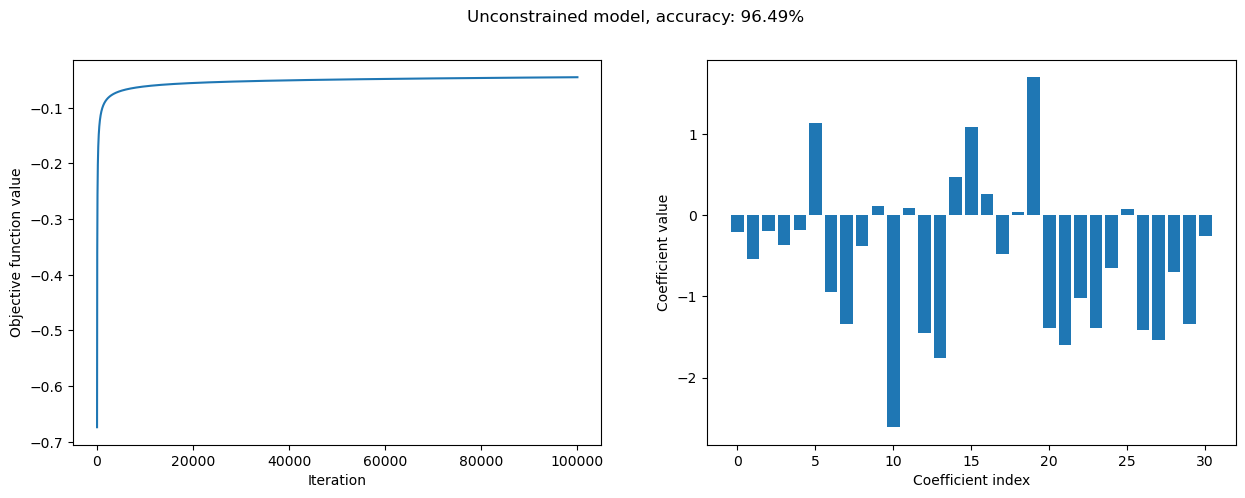

In [4]:
#Unconstrained model
model = LogisticRegression()
obj_hist = model.fit(X_train, y_train, 0.01, 100000)
accuracy = model.accuracy(X_test, y_test)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(obj_hist)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Objective function value')

ax[1].bar(range(X_train.shape[1]), model.theta)
ax[1].set_xlabel('Coefficient index')
ax[1].set_ylabel('Coefficient value')

fig.suptitle(f'Unconstrained model, accuracy: {accuracy*100:.2f}%')

The unconstrained model achieves an accuracy of 96.49% on the test set. Note that parameter 31 corresponds to the intercept.

---

#### **Non-negative model**

Text(0.5, 0.98, 'Non-negative model, penalty strength $r$=10, accuracy: 28.07%')

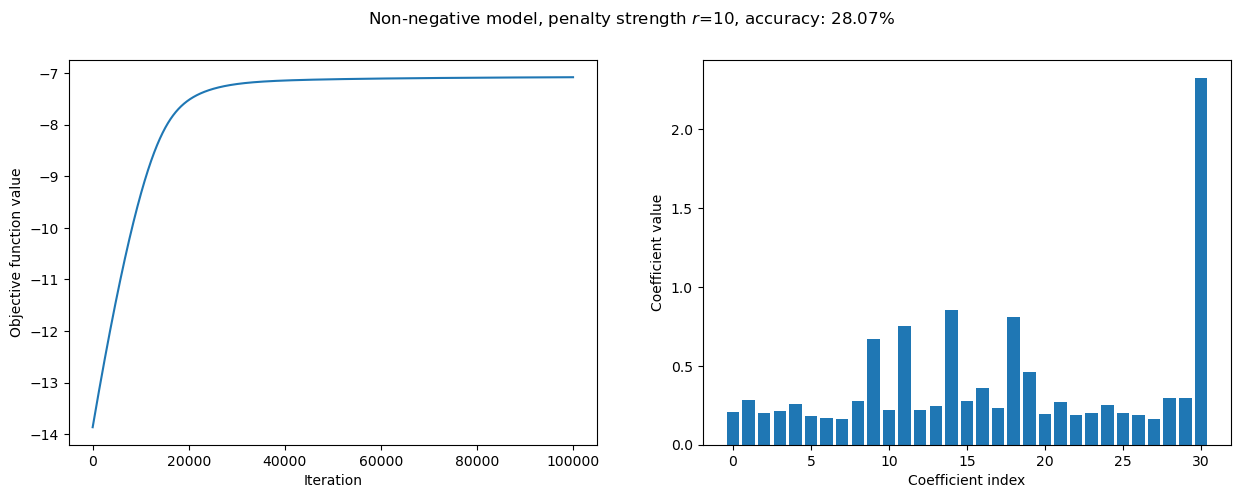

In [5]:
#Non-negative coefficients
model = LogisticRegression(barrier="nonnegative")
theta_init = np.ones(X_train.shape[1])
barrier_strength=10

obj_hist = model.fit(X_train, y_train, 0.0001, 100000, theta_init=theta_init, barrier_strength=barrier_strength)

accuracy = model.accuracy(X_test, y_test)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(obj_hist)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Objective function value')

ax[1].bar(range(X_train.shape[1]), model.theta)
ax[1].set_xlabel('Coefficient index')
ax[1].set_ylabel('Coefficient value')

fig.suptitle(f'Non-negative model, penalty strength $r$={barrier_strength}, accuracy: {accuracy*100:.2f}%')

Text(0.5, 0.98, 'Non-negative model, penalty strength $r$=10000, accuracy: 58.77%')

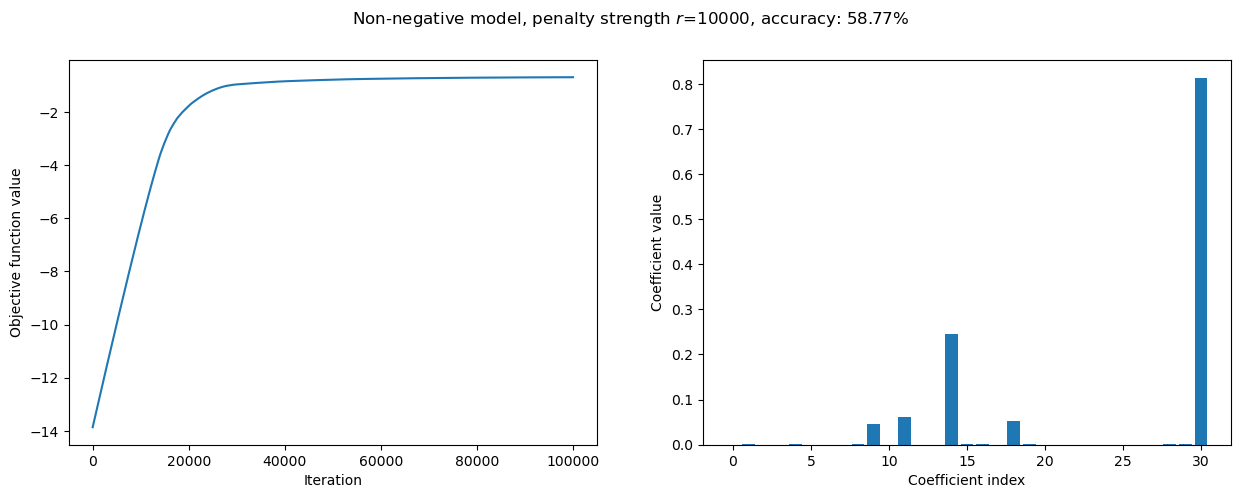

In [6]:
#Non-negative coefficients
model = LogisticRegression(barrier="nonnegative")
theta_init = np.ones(X_train.shape[1])
barrier_strength=10000

obj_hist = model.fit(X_train, y_train, 0.0001, 100000, theta_init=theta_init, barrier_strength=barrier_strength)

accuracy = model.accuracy(X_test, y_test)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(obj_hist)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Objective function value')

ax[1].bar(range(X_train.shape[1]), model.theta)
ax[1].set_xlabel('Coefficient index')
ax[1].set_ylabel('Coefficient value')

fig.suptitle(f'Non-negative model, penalty strength $r$={barrier_strength}, accuracy: {accuracy*100:.2f}%')

Increasing the penalty strength results in a sharper 'elbow' at the edge of the feasible region, which allows the optimal coefficients to move closer to the boundary. The non-negative model effectively zeroes many coefficients, and the accuracy improves - unsurprising, considering most coefficients were negative for the unconstrained model. Again, coefficient 31 corresponds to the intercept term.

**When would this be useful irl, why accuracy worse - always worse on test set, could be improved on unseen data**

---

#### **Ordered model**

Text(0.5, 0.98, 'Ordered model, penalty strength $r$=1000, accuracy: 87.72%')

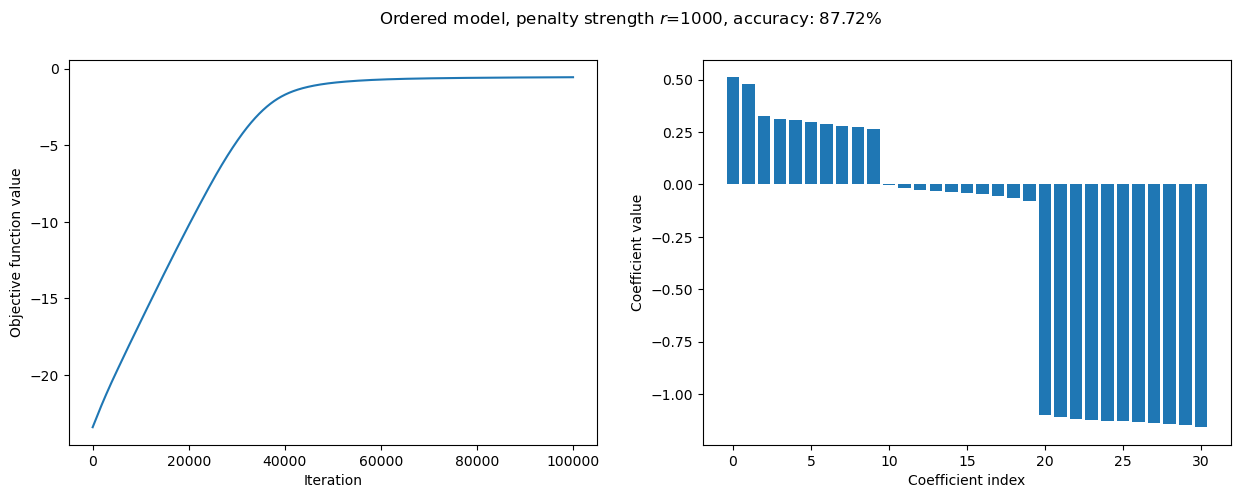

In [7]:
model = LogisticRegression(barrier="ordered")
theta_init = np.arange(3.1,0,-0.1)
barrier_strength=1000


obj_hist = model.fit(X_train, y_train, 0.0001, 100000, theta_init=theta_init, barrier_strength=barrier_strength)

accuracy = model.accuracy(X_test, y_test)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(obj_hist)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Objective function value')

ax[1].bar(range(X_train.shape[1]), model.theta)
ax[1].set_xlabel('Coefficient index')
ax[1].set_ylabel('Coefficient value')

fig.suptitle(f'Ordered model, penalty strength $r$={barrier_strength}, accuracy: {accuracy*100:.2f}%')

The log barrier function also appears to behave as expected, and achieves better accuracy than the unconstrained model. Many coefficients are approximately equal in value to the previous coefficient - the optimal coefficients are effectively at the boundary of the feasible space. The accuracy is worse than for the unconstrained model

**When would this be useful irl, why accuracy worse - always worse on test set, could be improved on unseen data** <br/>
**Short comment on value of penalty strength - pitfalls of too high, reinitialisation**